# Visualise KJMA Cell Dynamics

This Jupyter notebook is intended to provide an overview over the visualisation procedure for the KJMA approximation of DNA repair (see [A Quantitative Modelling Approach for DNA Repair on a Population Scale](https://github.com/leoTiez/jmak)). I assume that the model parameters are given. Subsequently, we derive the the nucleation $n$ and shape of the process $\sigma$, while fixing the growth rate $g=1$. We apply an MCMC approximation method to derive these parameters. Thus, we do not make any assumptions about the dimensionality of the growing forms. It should me mentioned, though, that the parameters could be derived anlytically when the dimension $m \in \mathbb{N}$. Sigma can be then calculated using the [volume formula for an $m$-ball](https://en.wikipedia.org/wiki/Volume_of_an_n-ball).

We recommend to download the interactive notebook and run the example yourself.

## Load python libraries and define functions

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import cv2
import imageio
from scipy.special import gamma
import pymc3 as pm

from IPython import display
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def repair_fraction(time, m, beta, theta):
    return (1 - np.exp(-(beta * time)**m)) * theta

In [4]:
def repair_fraction_over_time(to_time, m, beta, theta):
    return np.asarray([repair_fraction(t, m, beta, theta) for t in range(to_time)])

## Plot example repair processes

In [5]:
example_params = np.asarray([
    [1.5, 1/20., 0.9],
    [2., 1/35., 0.9],
    [2.5, 1/50., 0.9],
    [4, 1/50., 0.9],
])
to_time = 140

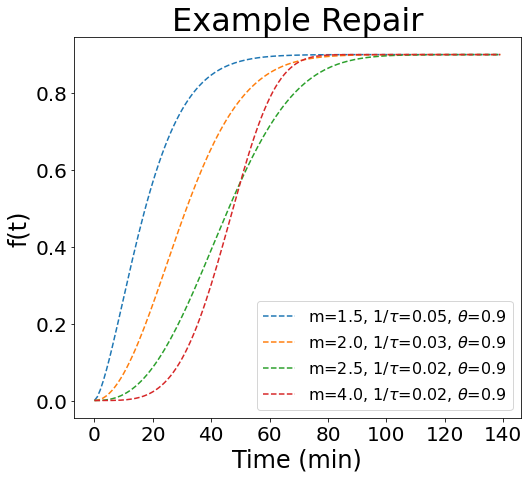

In [14]:
plt.figure(figsize=(8, 7))
plt.plot(
    repair_fraction_over_time(
        to_time, 
        example_params[:, 0],
        example_params[:, 1],
        example_params[:, 2]
    ),
    linestyle='--'
)
plt.xlabel('Time (min)', fontsize=24)
plt.ylabel('f(t)', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend([r'm=%s, $1/\tau$=%.2f, $\theta$=%s' % (p[0], p[1], p[2]) for p in example_params], fontsize=16)
plt.title('Example Repair', fontsize=32)
plt.show()

# Create data for MCMC approximation

We create some mock-up data to apply the MCMC approximation. We assume that the function $f(t)$ shows the temporal evolution of probability $p$ of a Bernoulli distribution. We exmplify the procedure with one parameter set, i.e. $m=2.5$, $1/\tau = 1/50$, and $\theta=0.9$ (see green line in plot above). 

In [15]:
example_kjma = 2
n_points = 100
obs_fraction = repair_fraction_over_time(to_time, *example_params[example_kjma])

# sample data points
observation = np.asarray([
    np.random.binomial(1, p=np.minimum(np.maximum(p, 0), 1), size=n_points)
    for p in obs_fraction
]).reshape(-1)
time_points = np.repeat(np.arange(to_time), n_points)

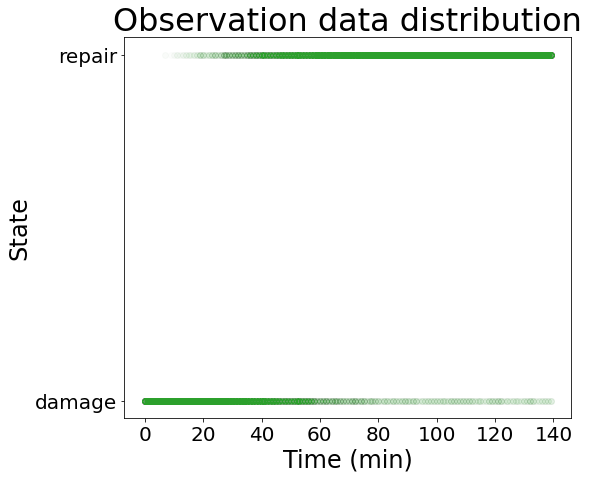

In [16]:
plt.figure(figsize=(8, 7))
plt.scatter(time_points, observation, alpha=.01, color='tab:green')
plt.xlabel('Time (min)', fontsize=24)
plt.ylabel('State', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks([0, 1], ['damage', 'repair'], fontsize=20)
plt.title('Observation data distribution', fontsize=32)
plt.show()

## Apply MCMC to determine $\sigma$ and $n$

The shape factor is dependent on the dimensionality $m$. This would be straightforward to compute if $m$ is an integer value (see link in introduction). However, non-integer values indicate non-symmetrical growth. This can be understood as spherical $m$-dimensional growth with a hole. Unfortunately, calculating the volume of the missing piece is not trivial. We apply therefore an approximation method for the sake of simplicity to determine possible values for $n$ and $\sigma$. It should be noted though that infinitely many combinations are technically possible. We restrict $n \in [0, 1]$ to make an interpretation as probability intuitive.

In [18]:
m = example_params[example_kjma, 0]  # m from observation
theta = example_params[example_kjma, 2]  # theta from observation
g = 1.  # fix growth rate of radius to 1 unit per time step 
n_samples = 2000
with pm.Model():
    n = pm.Bound(pm.Exponential, lower=0.0, upper=1.0)('n', lam=1., testval=.01)
    shape = pm.Bound(pm.Normal, lower=0)('shape', mu=np.pi, sigma=1, testval=np.pi)
    beta = ((shape * n * g**(m-1)))**(1./m)
    p = pm.Deterministic('p', repair_fraction(time_points, m, beta, theta))
    obs = pm.Bernoulli('obs', p, observed=observation)
    
    step = pm.Metropolis()
    cellmd_trace = pm.sample(n_samples, step=step, chains=5, return_inferencedata=False)

Multiprocess sampling (5 chains in 4 jobs)
CompoundStep
>Metropolis: [shape]
>Metropolis: [n]


/home/leo/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/leo/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/leo/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/leo/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/home/leo/.local/lib/python3.8/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 5 chains for 1_000 tune and 2_000 draw iterations (5_000 + 10_000 draws total) took 41 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effecti

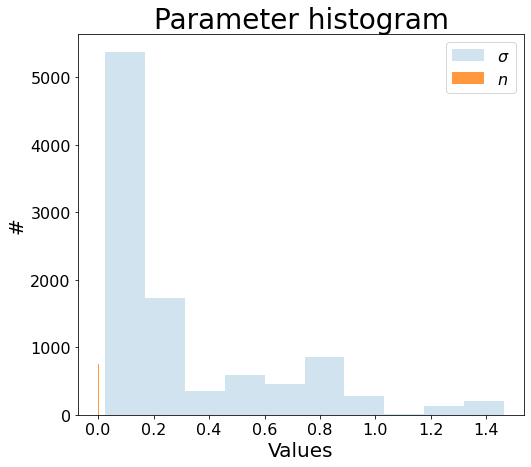

In [22]:
plt.figure(figsize=(8, 7))
plt.hist(cellmd_trace['shape'], alpha=.2, label=r'$\sigma$')
plt.hist(cellmd_trace['n'], alpha=.8, label=r'$n$')
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Values', fontsize=20)
plt.ylabel('#', fontsize=20)
plt.title('Parameter histogram', fontsize=28)
plt.show()

In [23]:
# Set parameter values
n_max = np.argmax(cellmd_trace['n'])
g_p = 1.
n_p = cellmd_trace['n'][n_max]
sig_p = cellmd_trace['shape'][n_max]

## Simulate transformation from *damaged* to *repaired*

In the following we visualise the repair process on a two dimensional grid. First, we define a class that represents the nucleation and updates the radius. We also implement a function that represents one simulation step. Every time step, the radius of existing nuclei grows by one. To calculate the surface on a two dimensional grid, the volume is calculated for the $m$-dimensional space and subsequently transfromed for a two-dimensional plane. A nucleation process starts with probability $p=n$ in untransformed space. 

In [24]:
class Nucleation:
    def __init__(self, x, y, m, g, sig, t):
        self.x = int(x)
        self.y = int(y)
        self.m = m 
        self.g = g
        self.sig = sig
        self.radius = 0.
        self.create_time=t
    
    def get_coordinates(self):
        return np.asarray([self.x, self.y])
    
    def update_radius(self, t):
        # fix radius growth to 1 per time step
        self.radius += self.g
        
    def calc_circular_radius(self):
        vol = self.sig * self.radius**(self.m-1)
        return int(np.sqrt(vol))

In [25]:
def simulation(t, state, nucleation_list, m, n, g, sig):
    # Growth
    for nucleation in nucleation_list:
        nucleation.update_radius(t)
        circ_radius = nucleation.calc_circular_radius()    
        state = cv2.circle(state, nucleation.get_coordinates(), circ_radius, 1., -1)
        
    nucleation_candidates = np.random.binomial(1, p=n, size=state.shape) == 1
    new_nucleation = zip(*np.where(np.logical_and(nucleation_candidates, state == 0.)))
    for x, y in new_nucleation:
        nucleation_list.append(Nucleation(x, y, m, g, sig, t))
        
    return state, nucleation_list

We now run the simulation for a time $t=$`to_time`. The two dimensional grid is updated and plotted every time step. It is possible to simulate growth from the left to the right by set `do_sort=True`.

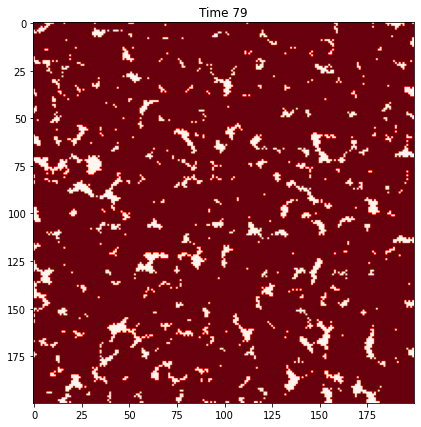

In [26]:
state = np.zeros((200, 200))
to_time = 80
nucleation_list = []
do_sort = False
save_gif = False
state_list = []
sim_rep_frac = []

norm = Normalize(vmin=0, vmax=1)
plt.figure(figsize=(8, 7))
ax = plt.gca()
for t in np.arange(to_time):
    state, nucleation_list = simulation(
        t,
        state, 
        nucleation_list, 
        example_params[example_kjma, 0],
        n_p,
        g_p,
        sig_p
    )
    
    try:
        ax.clear()
        
        if do_sort:
            y_sort = np.argsort(state).reshape(-1)
            x_sort = np.repeat(np.arange(state.shape[0]), state.shape[1]).reshape(-1)
            ax.imshow(state[x_sort, y_sort].reshape(state.shape), cmap='Reds', norm=norm)
            state_list.append(state[x_sort, y_sort].reshape(state.shape))
        else:
            ax.imshow(state, cmap='Reds', norm=norm)
            state_list.append(state.astype('uint8').copy() * 255)
        ax.set_title('Time %s' % t)
        fig = plt.gcf()
        fig.canvas.draw()
        
        coloured = np.sum(state == 1.)
        sim_rep_frac.append((coloured / state.size)* example_params[example_kjma, 2])
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
    except KeyboardInterrupt:
        break
    
if save_gif:
    save_name = 'sorted' if do_sort else 'random'
    imageio.mimsave('figures/gif/%s_500.gif' % save_name, state_list, format='GIF-PIL', fps=10)

We finally compare the visualisation with the model prediction. Note that the simulation is seemingly updated step-wise and exhibits a small but increasing difference towards the end. This is due to the numerical inaccuracies on a discrete two dimensional grid. Increasing the grid size can minimise this effect.

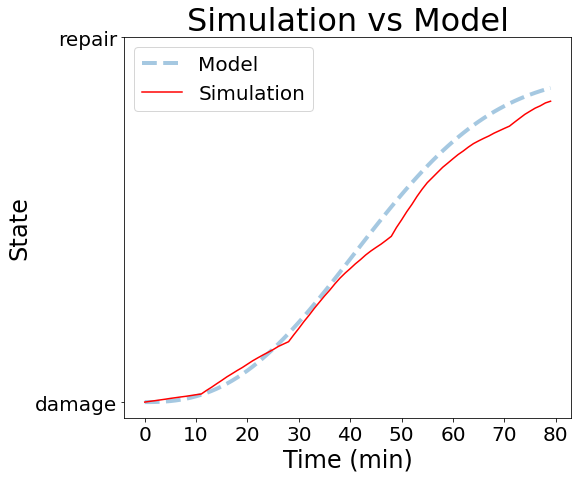

In [27]:
plt.figure(figsize=(8, 7))
plt.plot(
    repair_fraction_over_time(to_time, *example_params[example_kjma]),
    linestyle='--', 
    color='tab:blue', 
    label='Model',
    linewidth=4,
    alpha=.4
)
plt.plot(np.asarray(sim_rep_frac), color='red', label='Simulation')
plt.xlabel('Time (min)', fontsize=24)
plt.ylabel('State', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks([0, 1], ['damage', 'repair'], fontsize=20)
plt.legend(fontsize=20)
plt.title('Simulation vs Model', fontsize=32)
plt.show()